# AI Launch Lab - Sea Ice Movement Challenge - Training

In [1]:
import pandas as pd
import pickle
import os 
pd.options.mode.chained_assignment = None
import datetime
import numpy as np
import os
import zipfile
import modules.ml_pipeline.readdata as mlpp
import sys

Load the data from disk and display it

In [2]:
# unzip the zip dataset
with zipfile.ZipFile('data/converted_full.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Load the raw data to disk
input_path = "data/converted.csv"
df = pd.read_csv(input_path)

# Convert all column names to lower case and display the dataframe 
df = df.rename(str.lower, axis='columns')

## Data Preprocessing

Here we will clean the data a bit, and remove any points that are either NaNs, rows that are duplicates or rows that are illogical according to the definition of the problem. 

In [3]:
# Do some manipulations on the data and clean it (remove rows of all NaNs, remove duplicates, etc.)

# Remove any rows that have buoy velocity/mag =0 
df = df.drop(df[df["buoy_vel_mag"] == 0].index)

# Remove any rows that have very low ice_thickness  
"""
sea ice concentration of 0.5 means that the surroundings of the buoy is 50% sea ice and 50% open water. So ice concentration of 
1 is full ice cover, while a concentration of 0.1 means there’S barely any ice left at that location!
"""
df = df.drop(df[df["ice_thickness"] < 0.1].index)

# This section could be further refined at a later time.
# We will leave the month for now because it could be an indicator of weather/season 

# Print the dataframe dimensions
print("Sea Ice Movement Datasets")
print("Dataframe final shape: ", df.shape)
display(df)

Sea Ice Movement Datasets
Dataframe final shape:  (327042, 21)


,index,year,month,day,doy,x_ease,y_ease,u_buoy,v_buoy,id_buoy,...,v_era5,sic_cdr,d2c,ice_thickness,buoy_lat,buoy_lon,buoy_vel_mag,buoy_vel_dir,wind_vel_mag,wind_vel_dir
0,0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,...,-0.321260,0.990195,522.523298,3.189743,78.007070,-128.549129,1.370671,2.191824,6.711849,3.189490
1,1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,...,-0.674205,0.966372,412.767669,2.484009,74.498024,-119.750294,0.741408,0.520564,6.851881,3.240164
2,2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,...,1.123955,0.996022,362.547379,2.474106,74.003619,-134.786524,1.187695,2.934923,8.896751,3.014921
3,3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,...,-1.035410,0.982681,381.025629,3.740522,81.019593,-145.578020,0.920127,0.028026,1.496117,3.905953
4,4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,...,2.537787,0.990302,521.535334,3.188522,78.002077,-128.560665,1.300527,1.273525,3.338513,2.278041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329883,339472,2019,12,30,364,173.589722,117.012932,-13.455300,-10.662800,25560,...,-4.199740,1.000000,470.197315,0.933125,75.686986,-96.341501,17.168005,3.811734,8.234026,3.676847
329884,339473,2019,12,30,364,193.232056,172.742004,-0.981225,-11.698400,44880,...,-6.012877,1.000000,702.312813,1.517084,86.513431,-29.153877,11.739478,4.628723,6.522125,4.314615
329885,339474,2019,12,30,364,208.421234,142.049896,-7.247925,-5.289890,53005,...,-0.381765,1.000000,360.491321,1.164462,79.286760,-53.579091,8.973035,3.772087,4.630856,3.224141
329886,339475,2019,12,30,364,145.264023,146.109741,-0.913761,2.182150,95020,...,1.119087,1.000000,393.799208,2.010032,79.025667,-135.924079,2.365742,1.967356,2.240471,0.523007


### TO-DO - Add Outlier Removal 

In [4]:
# Code for outlier removal

## Data Analysis

### Visualize the variables using a scatter plot

The scatterplot matrix helps to quickly identify which variables are correlated with each other and what kind of relationships they share. We can tell whether some variables are positively or negatively correlated. The strongest relationships lie where a thin line is visible.

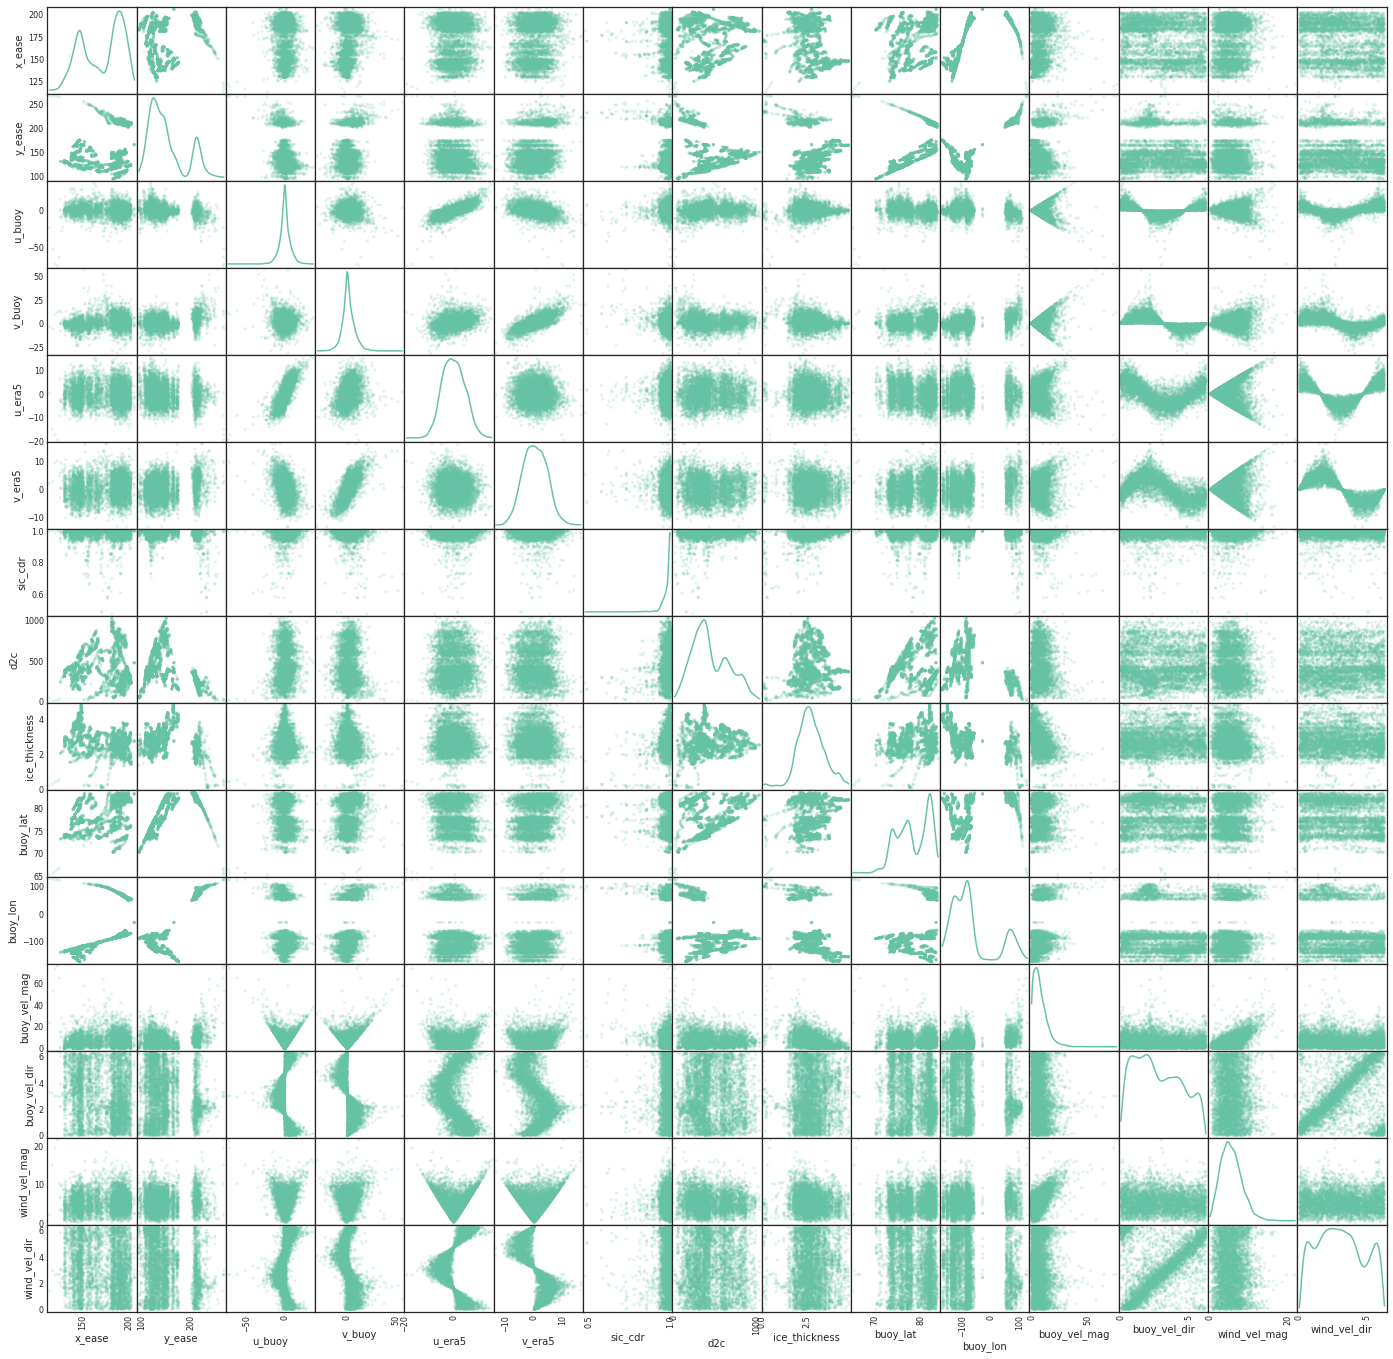

In [5]:
from pandas.plotting import scatter_matrix, andrews_curves, parallel_coordinates
import matplotlib.pyplot as plt

# plot some of the features 
scatter_df = df.drop(["index","year","day", "doy", "month", "id_buoy"], axis=1)

# create a scatter matrix of the training data 
scatter = scatter_matrix(scatter_df.head(5000), alpha=0.2, figsize=(24, 24), diagonal="kde")
plt.savefig('sea_ice_velocity_scatter_matrix.png')

In [6]:
training_targets = df[["wind_vel_mag","wind_vel_dir"]]

print("Target Variables")
display(training_targets)

Target Variables


,buoy_vel_mag,buoy_vel_dir
0,1.370671,2.191824
1,0.741408,0.520564
2,1.187695,2.934923
3,0.920127,0.028026
4,1.300527,1.273525
...,...,...
329883,17.168005,3.811734
329884,11.739478,4.628723
329885,8.973035,3.772087
329886,2.365742,1.967356


Observing the scatter plot, there are some interesting trends to notice here.

1) We are trying to predict the buoy velocity direction (buoy_vel_dir) , and buoy velocity magnitude (buoy_vel_mag). There is a strong relationship that is visible between the buoy_vel_mag, wind velocity magnitude (wind_velocity_mag), and (a small but noticeable) ice thickness. This makes sense, because the stronger the wind, the further the buoy will be pushed, and the more ice under the buoy, the more the wind will need to be strong to push the mass under it. 

2) Looking at buoy_vel_dir, it is clear that there is a relationship between this variable and the wind velocity dir (wind_vel_dir), which is also expressed by v_era5 and u_era5. The variables that are inversely correlated, such as the v-component and the wind (v_era5) and the u-component of the wind (u_era5), and buoy_velocity magnitude. If the dot product of v and u is low, then the buoy is stationary. This also makes a lot of sense because the buoy will be pushed by the wind, so they must move in the same direction!

### Define the variables that we will use for training. 

In [7]:
# Drop the time related and insignificant columns 
training_data = df.drop(["index","year","day", "d2c", "buoy_lat", "buoy_lon", "doy", "month", "id_buoy","year","day","sic_cdr", "doy", "id_buoy", "x_ease", "y_ease", "u_buoy", "v_buoy","buoy_vel_mag","buoy_vel_dir"], axis = 1)

# Our final training dataset will include the following variables that we will use for training.
print("Final Training Dataset: ")
display(training_data)

Final Training Dataset: 


,u_era5,v_era5,ice_thickness,wind_vel_mag,wind_vel_dir
0,-6.704156,-0.321260,3.189743,6.711849,3.189490
1,-6.818630,-0.674205,2.484009,6.851881,3.240164
2,-8.825469,1.123955,2.474106,8.896751,3.014921
3,-1.079951,-1.035410,3.740522,1.496117,3.905953
4,-2.169171,2.537787,3.188522,3.338513,2.278041
...,...,...,...,...,...
329883,-7.082469,-4.199740,0.933125,8.234026,3.676847
329884,-2.526544,-6.012877,1.517084,6.522125,4.314615
329885,-4.615093,-0.381765,1.164462,4.630856,3.224141
329886,1.940967,1.119087,2.010032,2.240471,0.523007


##  Model Training

Next, we will create a series of models to create our predictor. There are two approaches we could use for this problem.Because we are trying to estimate numerical values, we will be performing a regression: 

1) In the first case, we will be attempting a Multiouput Regression, since we are estimating two values that correspond to buoy_vel_mag and buoy_vel_dir. Both values will be predicted simulataneously using the training data.

2) The next approach could be to construct two seperate models (one for buoy velocity direction and magnitude) that will each be trained independently. This could allow for a more precise prediction of each variable based on what we observed in the scatter plot. 

In [8]:
# Evaluate multioutput regression models
%matplotlib inline
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Split the dataset into training and validation sets. 

In [9]:
# test_size: what proportion of original data is used for test set
train_data, test_data, train_labels, test_labels = train_test_split(
    training_data, training_targets, test_size= 0.25)

# show the sizes of the training and test sets
print("Training data shape: ", train_data.shape)
print("Training labels shape: ", train_labels.shape)

print("Test data shape: ", test_data.shape)
print("Test labels shape: ", test_labels.shape)

Training data shape:  (245281, 5)
Training labels shape:  (245281, 2)
Test data shape:  (81761, 5)
Test labels shape:  (81761, 2)


### Normalizing the variables before training 

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

#scaler = MinMaxScaler()
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_data)

# Apply transform to both the training set and the test set.
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# display the normalized data
display(train_data)

array([[ 0.90559261, -0.10343376,  0.6090171 , -0.5910872 ,  1.79640517],
       [-1.54733934, -1.06505598,  2.66967058,  0.95473062,  0.34790805],
       [-2.27896459,  0.23999931,  0.22137931,  1.76236086, -0.02755338],
       ...,
       [-1.01813049,  1.35543968,  0.32386555,  0.79480701, -0.4682844 ],
       [ 1.62604331,  0.92041234,  1.12507054,  1.01732811, -1.4054023 ],
       [ 1.01603041,  0.83977797, -0.98388526,  0.14123341, -1.30002065]])

### Training 

#### Scenario #1: Multioutput Regression 
Create a series of models and calculate the predictions (buoy_vel_mag, buoy_vel_dir).

#####  Prepare K-Cross Validation 

K-Cross validation is a common way to evaluate machine learning models on a dataset. The k-fold cross-validation procedure divides a limited dataset into k non-overlapping folds. Each of the k folds is given an opportunity to be used as a held-back test set, whilst all other folds collectively are used as a training dataset. A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported.

In [11]:
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3)

In [12]:
# K-NEAREST NEIGHBOR MODEL 

# create model
regr_KNN = KNeighborsRegressor()

# train the model 
print("Training KNN Regressor...")
start = time.time()
regr_KNN.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# evaluate model
scores = cross_val_score(regr_KNN, test_data, test_labels, scoring="neg_mean_squared_error", cv=cv)
# force the scores to be positive
scores = absolute(scores)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Training KNN Regressor...
Model training time:  0.2988913059234619
Accuracy: 16.856 (0.634)


In [13]:
"""
# K-NEAREST NEIGHBOR MODEL 

# create model
regr_KNN_vel = KNeighborsRegressor()

# train the model 
print("Training KNN Regressor...")
start = time.time()
regr_KNN_vel.fit(train_data, train_labels["buoy_vel_mag"])
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_KNN=regr_KNN_vel.predict(test_data)
print("Regression Score: ", regr_KNN_vel.score(test_data, test_labels["buoy_vel_mag"]))
"""

'\n# K-NEAREST NEIGHBOR MODEL \n\n# create model\nregr_KNN_vel = KNeighborsRegressor()\n\n# train the model \nprint("Training KNN Regressor...")\nstart = time.time()\nregr_KNN_vel.fit(train_data, train_labels["buoy_vel_mag"])\nend = time.time()\nprint("Model training time: ", end-start)\n\n# Calculate the new predictions and print the regression score:\nprint("Predicting scores...")\ny_KNN=regr_KNN_vel.predict(test_data)\nprint("Regression Score: ", regr_KNN_vel.score(test_data, test_labels["buoy_vel_mag"]))\n'

In [14]:
"""
# K-NEAREST NEIGHBOR MODEL 

# create model
regr_KNN_dir = KNeighborsRegressor()

# train the model 
print("Training KNN Regressor...")
start = time.time()
regr_KNN_dir.fit(train_data, train_labels["buoy_vel_dir"])
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_KNN=regr_KNN_dir.predict(test_data)
print("Regression Score: ", regr_KNN_dir.score(test_data, test_labels["buoy_vel_dir"]))
"""

'\n# K-NEAREST NEIGHBOR MODEL \n\n# create model\nregr_KNN_dir = KNeighborsRegressor()\n\n# train the model \nprint("Training KNN Regressor...")\nstart = time.time()\nregr_KNN_dir.fit(train_data, train_labels["buoy_vel_dir"])\nend = time.time()\nprint("Model training time: ", end-start)\n\n# Calculate the new predictions and print the regression score:\nprint("Predicting scores...")\ny_KNN=regr_KNN_dir.predict(test_data)\nprint("Regression Score: ", regr_KNN_dir.score(test_data, test_labels["buoy_vel_dir"]))\n'

In [15]:
# LINEAR REGRESSION MODEL 

# create model
regr_LR = LinearRegression()

# train the model 
print("Training Linear Regressor...")
start = time.time()
regr_LR.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)


# evaluate model
scores = cross_val_score(regr_LR, test_data, test_labels, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
# force the scores to be positive
scores = absolute(scores)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Training Linear Regressor...
Model training time:  1.133134126663208
Accuracy: 15.881 (0.522)


In [16]:
# DECISION TREE MODEL 

# create model
regr_DT = DecisionTreeRegressor()

# train the model 
print("Training Decision Tree Regressor...")
start = time.time()
regr_DT.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# evaluate model
scores = cross_val_score(regr_DT, test_data, test_labels, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
# force the scores to be positive
scores = absolute(scores)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Training Decision Tree Regressor...
Model training time:  3.2294487953186035
Accuracy: 28.303 (0.900)


In [17]:
"""NOT WORKING
# RANDOM FORESTS  MODEL 

# create model
regr_RF = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=0))
# train the model 
print("Training Random Forest Regressor...")
start = time.time()
regr_RF.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)
"""

'NOT WORKING\n# RANDOM FORESTS  MODEL \n\n# create model\nregr_RF = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=0))\n# train the model \nprint("Training Random Forest Regressor...")\nstart = time.time()\nregr_RF.fit(train_data, train_labels)\nend = time.time()\nprint("Model training time: ", end-start)\n'

In [18]:
# SUPPORT VECTOR REGRESSOR MODEL

# create model
regr_SVM = MultiOutputRegressor(LinearSVR())

# train the model 
print("Training SVM Regressor...")
start = time.time()
regr_SVM.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# evaluate model
scores = cross_val_score(regr_SVM, test_data, test_labels, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
# force the scores to be positive
scores = absolute(scores)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Training SVM Regressor...
Model training time:  10.903422594070435
Accuracy: 16.445 (0.721)


### Scoring the different models 

Next, we will assess each model and see how well they did on various aspects of the problem. 

In [19]:
from sklearn.metrics import explained_variance_score, max_error, mean_squared_error, r2_score, mean_absolute_error

### Performance metrics explained: 

1) *explained_variance_score*: Explained variance regression score function. Best possible score is 1.0, lower values are worse.

2) *max_error*: Max_error metric calculates the maximum residual error.

3) *mean_absolute_error*: Mean absolute error regression loss. MAE output is non-negative floating point. The best value is 0.0.

4) *mean_squared_error*: Mean squared error regression loss.A non-negative floating point value (the best value is 0.0), or an array of floating point values, one for each individual target.

5) *r2_score*: R^2 (coefficient of determination) regression score function. est possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [20]:
# Calculate the predictions for each model 

y_KNN = regr_KNN.predict(test_data)
y_LR = regr_LR.predict(test_data)
y_DT = regr_DT.predict(test_data)
#y_RF = regr_KNN.predict(test_data)
y_SVM = regr_SVM.predict(test_data)

In [21]:
#model_names = ["K-Nearest-Neighbor", "Linear Regression", "Decision Trees", "Random Forests", "MultiOutput Random Forests", "SVM"]
#predictions = [y_KNN, y_LR, y_DT, y_RF, y_SVM]

# Create an iterator
model_names = ["K-Nearest-Neighbor", "Linear Regression", "Decision Trees", "SVM"]
predictions = [y_KNN, y_LR, y_DT, y_SVM]

In [22]:
# Print the predictions for every model to screen 
for i, j in list(zip(predictions, model_names)):
    print(f"Predicting {j} scores...\n")
    
    # Calculate the regression scores
    print("Explained Variance Regression Score: ", explained_variance_score(i, test_labels))
    print("Mean Absolute Error: ", mean_absolute_error(i, test_labels)) 
    print("RMSE: ", mean_squared_error(i, test_labels))
    print("R Squared Score: ", r2_score(i, test_labels))
    print("\n")

Predicting K-Nearest-Neighbor scores...

Explained Variance Regression Score:  -0.001070723691292741
Mean Absolute Error:  2.3303784271674504
RMSE:  16.3003604616448
R Squared Score:  -0.001078768699499355


Predicting Linear Regression scores...

Explained Variance Regression Score:  -0.5599462459040965
Mean Absolute Error:  2.3937973082633572
RMSE:  15.87780009701413
R Squared Score:  -0.5599499641875236


Predicting Decision Trees scores...

Explained Variance Regression Score:  0.05882602113868424
Mean Absolute Error:  2.791480351405748
RMSE:  26.149795188197395
R Squared Score:  0.05882431896188911


Predicting SVM scores...

Explained Variance Regression Score:  -0.30677207705469156
Mean Absolute Error:  2.3414063243767678
RMSE:  16.45147230105347
R Squared Score:  -0.3300921579951732




# Scoring and Visualizing the Results 

Here, we take a look at the regression results for each model and compare them. Using this, we can select the most performant one and try and reduce overfitting even more in the next step. 


In [23]:
# Define the metrics for scoring provided by the challenge creators
def sea_ice_score(y_pred, y_true):  
    # convert the predictions array to a dataframe 
    y_pred = pd.DataFrame(data=y_pred, columns=y_true.columns)
    
    # calculate the root mean squared error between the two variables 
    rmse = mean_squared_error(y_true, y_pred)
    return y_pred, rmse 

Overall K-Nearest-Neighbor RMSE:  16.3003604616448
Overall Linear Regression RMSE:  15.87780009701413
Overall Decision Trees RMSE:  26.149795188197395
Overall SVM RMSE:  16.45147230105347


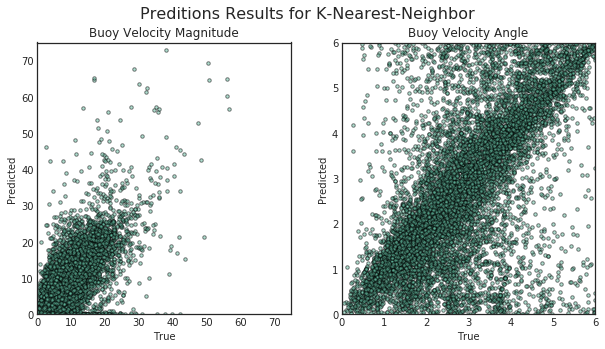

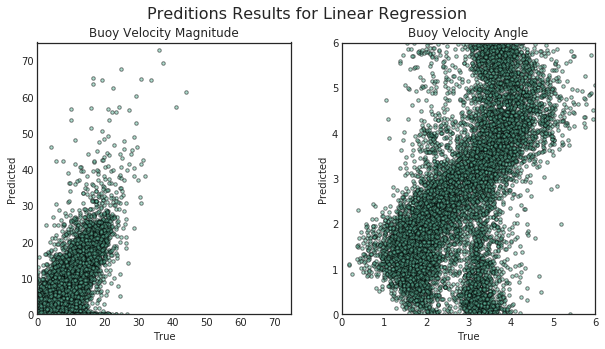

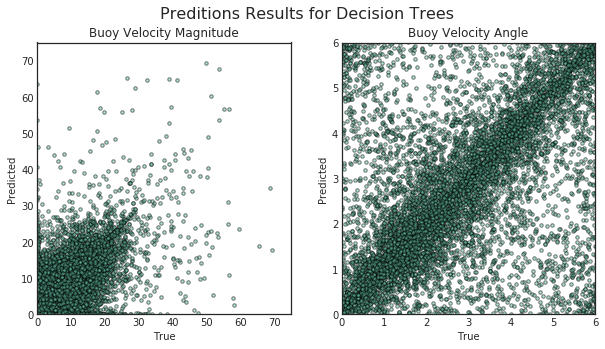

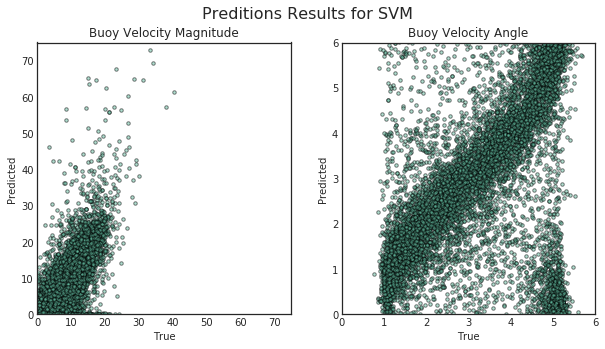

In [24]:
# Iterate through the results and plot them (first 10 000 points)
for i, j in zip(predictions, model_names):
    i, rmse = sea_ice_score(i, test_labels)
    print(f"Overall {j} RMSE: ", rmse)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    fig.suptitle('Preditions Results for ' + j, fontsize=16)
    
    ax1.scatter(i["buoy_vel_mag"].head(10000), test_labels["buoy_vel_mag"].head(10000), s=12, edgecolors='k', alpha=0.5)
    ax1.set_ylabel("Predicted")
    ax1.set_xlabel("True")
    ax1.set_xlim(0, 75)
    ax1.set_ylim(0, 75)
    #ax1.legend()
    ax1.set_title('Buoy Velocity Magnitude')
    
    ax2.scatter(i["buoy_vel_dir"].head(10000), test_labels["buoy_vel_dir"].head(10000), s=12, edgecolors='k', alpha=0.5)
    ax2.set_ylabel("Predicted")
    ax2.set_xlabel("True")
    ax2.set_xlim(0, 6)
    ax2.set_ylim(0, 6)
    #ax2.legend()
    ax2.set_title('Buoy Velocity Angle')

Looking at these figures, we can see that the models can somewhat predict the correct coordinates at the beginning of the training cycle. However, there does seem to be a lot of error in the predictions of the buoy velocity angle. It would be interesting to investigate why this is. Another thing to take note of is how the predictions evolve over time, particularly for the angle. The dataset is not shuffled during training, so it occurs chronologically from the years 1979 to 2019. Velocity magnitude seems the best predicted by LR and SVM.

Overall K-Nearest-Neighbor RMSE:  16.3003604616448
Overall Linear Regression RMSE:  15.87780009701413
Overall Decision Trees RMSE:  26.149795188197395
Overall SVM RMSE:  16.45147230105347


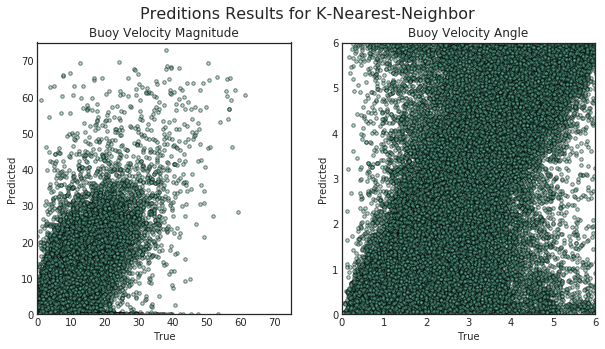

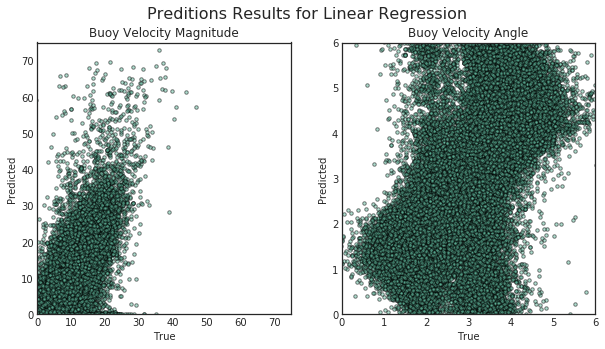

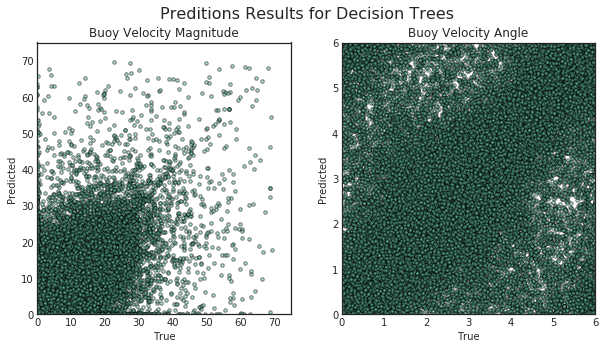

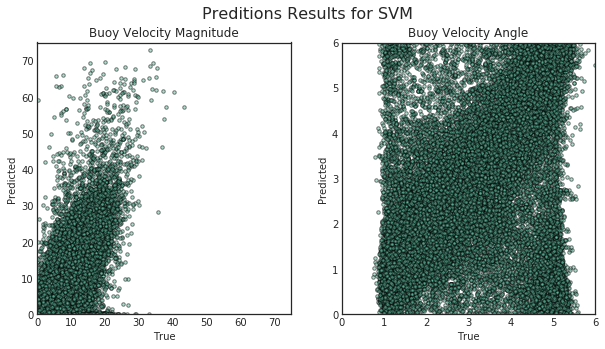

In [25]:
# Iterate through the results and plot them (first 10 000 variables)
for i, j in zip(predictions, model_names):
    i, rmse = sea_ice_score(i, test_labels)
    print(f"Overall {j} RMSE: ", rmse)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    fig.suptitle('Preditions Results for ' + j, fontsize=16)
    
    ax1.scatter(i["buoy_vel_mag"].head(60000), test_labels["buoy_vel_mag"].head(60000), s=12, edgecolors='k', alpha=0.5)
    ax1.set_ylabel("Predicted")
    ax1.set_xlabel("True")
    ax1.set_xlim(0, 75)
    ax1.set_ylim(0, 75)
    #ax1.legend()
    ax1.set_title('Buoy Velocity Magnitude')
    
    ax2.scatter(i["buoy_vel_dir"].head(60000), test_labels["buoy_vel_dir"].head(60000), s=12, edgecolors='k', alpha=0.5)
    ax2.set_ylabel("Predicted")
    ax2.set_xlabel("True")
    ax2.set_xlim(0, 6)
    ax2.set_ylim(0, 6)
    #ax2.legend()
    ax2.set_title('Buoy Velocity Angle')

The predictions of magnitude seem to improve a bit, but velocity worsens quite a lot as we retrieve test results for later years. It could be that there is actually a chronological component in this problem that we need to take note of in order to improve prediction capability. I think at this point, the SVM wins for predicting velocity magnitude.

#### Scenario #2: Simple Regression 
As we can see, the output for multivariable regression was not very promising. The next step would be to analyze the variables individually and see if results can be improved. 

In [26]:
# code for simple regression 

## Final Evaluation using the test set

In [27]:
# Import the test file needed for the final evalution 
test_path = "data/DRIFT_DATA_TEST.csv"
test_df = pd.read_csv(input_path)

In [28]:
# Do some manipulations on the data and clean it (remove rows of all NaNs, remove duplicates, etc.) before making predictions 

# Remove any rows that have buoy velocity/mag =0 
test_df = test_df.drop(test_df[test_df["buoy_vel_mag"] == 0].index)

# Print the dataframe dimensions
print("Dataframe final shape: ", test_df.shape)
display(final_test)

Dataframe final shape:  (329888, 21)


NameError: name 'final_test' is not defined

In [ ]:

import math 

def caonvert_vel_vector(u,v):
    mag = math.sqrt(u**2 + v**2)
    dir = math.atan2(v, u)
    if dir < 0:
        dir += 2*3.1416
    
    return mag, dir


'''
data cleaning up
'''
# Remove any rows that have buoy velocity/mag =0 
data = data.drop(data[data["u_buoy"]*data["v_buoy"] == 0].index)
data = data.reset_index()

# average the ice thickness from two measurements
temp = [None]*data.shape[0]
# iterate through all the rows and check if thickness is 0
for index, row in data.iterrows():
    if row["h_piomas"] == 0 :  
        if row["h_cs2smos"] > 0: 
            temp[index] = row["h_cs2smos"]
        elif row['sic_CDR'] < 0.001:
            temp[index] = 0
            
    elif row["h_piomas"] > 0:
        if row["h_cs2smos"] > 0:
            temp[index] = (row["h_cs2smos"] + row["h_piomas"])/2
        else: 
            temp[index] = row["h_piomas"]
            
    else:
         if row["h_cs2smos"] > 0:
            temp[index] = row["h_cs2smos"]
   
        

data["ice_thickness"] = temp      



# drop original thickness columns
data = data.drop(['h_piomas', 'h_cs2smos'], axis = 1)

# frop nan rows
#data = data.dropna()

# convert x_EASE and y_EASE to lat and lon
# convert velocity components to magnitude and angle
#lats = []
#lons = []
buoy_vel_mags = []
buoy_vel_dirs = []
wind_vel_mags = []
wind_vel_dirs = []

for index, row in data.iterrows(): 
    # coordinate conversion
    #x = row['x_EASE']
    #y = row['y_EASE']
    #lat, lon = interpolate_coordinate(x, y, grid)
    #lats.append(lat)
    #lons.append(lon)

    # buoy velocity conversion
    buoy_mag, buoy_dir = caonvert_vel_vector(row['u_buoy'], row['v_buoy'])
    buoy_vel_mags.append(buoy_mag)
    buoy_vel_dirs.append(buoy_dir)

    # wind velocity conversion
    wind_mag, wind_dir = caonvert_vel_vector(row['u_ERA5'], row['v_ERA5'])
    wind_vel_mags.append(wind_mag)
    wind_vel_dirs.append(wind_dir)

# add the converted data to dataset
#data['buoy_lat'] = lats
#data['buoy_lon'] = lons
data['buoy_vel_mag'] = buoy_vel_mags
data['buoy_vel_dir'] = buoy_vel_dirs
data['wind_vel_mag'] = wind_vel_mags
data['wind_vel_dir'] = wind_vel_dirs

display(data)

In [ ]:
final_test = data.drop(["index", "x_EASE", "sic_CDR", "y_EASE", "month", "year","day", "doy", "id_buoy", "u_buoy", "v_buoy","buoy_vel_mag","buoy_vel_dir"], axis = 1)
print(final_test.shape)
display(final_test)
final_test = final_test.fillna(test_data.mean())
print(final_test.shape)

In [ ]:
final_test_scaled = scaler.transform(final_test)
final_predictions =regr_KNN.predict(final_test_scaled)

print(final_predictions)
y_KNN = pd.DataFrame(data=final_predictions, columns=test_labels.columns)
print(y_KNN)

y_KNN.to_csv("predictions.csv")

# Saving the model

Models will be scored based on the metrics provided in the challenge description. That is the difference between the predicted estimate values and the actual true values. 

In [ ]:
y_KNN.to_csv("predictions.csv")

In [ ]:
# create our custom scoring function
from sklearn.metrics import mean_squared_error 

def sea_ice_score(y_true, y_pred):  
    y_pred = pd.DataFrame(data=y_pred, columns=y_true.columns)
    rmse = mean_squared_error(y_true, y_pred)
    return y_true, rmse 